In [1]:
import numpy as np
import sys
sys.path.append("/home/jjwhit/rcGAN")
from data.lightning.MassMappingDataModule import MMDataTransform
import matplotlib.pyplot as plt

data_dir = "/share/gpu0/jjwhit/samples/ks/rmse/"

/home/jjwhit/rcGAN/fastmri/__init__.py:16: UserWarning: Could not retrieve fastmri version!
  warnings.warn("Could not retrieve fastmri version!")


In [26]:
def psnr(a:np.ndarray, b:np.ndarray, mask:bool)->float:
    '''
    args:
        a (np.ndarray): ground truth
        b (np.ndarray): reconstruction
        mask (bool): mask
    returns:
        psnr (float): peak signal-to-noise ratio
    '''
    a = a[mask==1]
    b = b[mask==1]
    mse = np.mean((a-b)**2)
    r = a.max()
    return 10*np.log10(r/mse)

In [3]:
# COSMOS mask and stds of noise

mask =  np.load('/home/jjwhit/rcGAN/mass_map_utils/cosmos/cosmos_mask.npy', allow_pickle=True
).astype(bool)
std1 = np.load('/home/jjwhit/rcGAN/mass_map_utils/cosmos/cosmos_std1.npy', allow_pickle=True)
std2 = np.load('/home/jjwhit/rcGAN/mass_map_utils/cosmos/cosmos_std2.npy', allow_pickle=True)
im_size = 300


kernel = MMDataTransform.compute_fourier_kernel(im_size)

In [28]:
all_psnr_vals = []
for map in range (1,1001):
    np_gts = np.load(data_dir+f"np_gt_{map}.npy")
    np_samps = np.load(data_dir+f"np_samps_{map}.npy")
    gt = np_gts.real

    psnr_vals = []
    for n in range(1,33):
        # Average the first `n` posterior samples to create a reconstruction
        recon = np.mean(np_samps[:n].real, axis=0)
        
        # Calculate PSNR for this reconstruction
        psnr_value = psnr(recon, np_gts.real, mask)
        psnr_vals.append(psnr_value)
    all_psnr_vals.append(psnr_vals)

In [29]:
all_psnr_vals = np.array(all_psnr_vals)

In [30]:
mean_psnr_vals = np.mean(all_psnr_vals, axis=0)
std_psnr_vals = np.std(all_psnr_vals, axis=0)


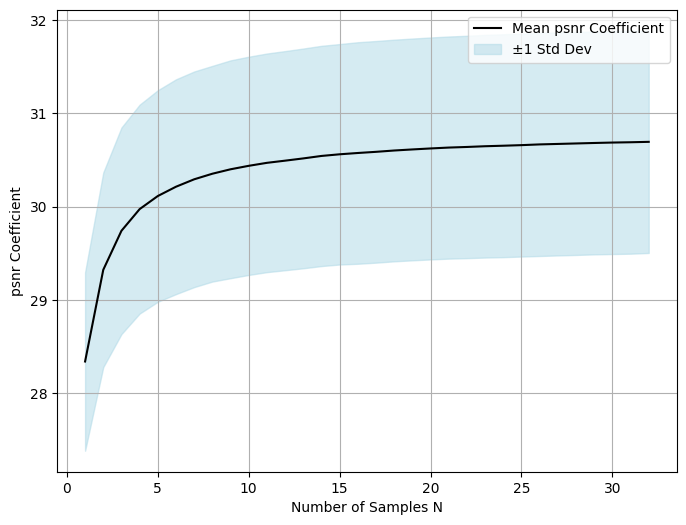

In [31]:
n_values = np.arange(1, 33)

# Plot the mean psnr values
plt.figure(figsize=(8, 6))
plt.plot(n_values, mean_psnr_vals, label='Mean psnr Coefficient', color='black')

# Shade the area between mean ± 1 standard deviation
plt.fill_between(n_values, 
                 mean_psnr_vals - std_psnr_vals, 
                 mean_psnr_vals + std_psnr_vals, 
                 color='lightblue', alpha=0.5, label='±1 Std Dev')

# Add labels and title
plt.xlabel('Number of Samples N')
plt.ylabel('psnr Coefficient')
plt.grid(True)
plt.legend()

# Show the plot
# plt.show()
plt.savefig('/share/gpu0/jjwhit/plots/ks/rmse/psnr_vs_n.png', bbox_inches='tight', dpi=300)